In [ ]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score
#NLP Libraries
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold
import random as rn


In [ ]:
!pip install -U path.py
import os
from path import Path
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path_lie = Path("/content/drive/MyDrive/Tien-297/Real-life_Deception_Detection_2016/Transcription/Deceptive")
files_lie = [file for file in os.listdir(path_lie) if not file.startswith('.')]
text = []
for file in files_lie:
    with open(path_lie+"/"+file, 'r') as f:
        text.append(f.read().replace('\r\n', ''))
df = pd.DataFrame(text, columns = ['Speech'])
df['label'] = 'Lie'
path_truth = Path("/content/drive/MyDrive/Tien-297/Real-life_Deception_Detection_2016/Transcription/Truthful")
files_truth = [file for file in os.listdir(path_truth) if not file.startswith('.')]

for file in files_truth:
    with open(path_truth+"/"+file, 'r', encoding="utf8") as f:
        text = [f.read().replace('\r\n', ''),'Truth']
        df.loc[len(df.index)] = text
df

,Speech,label
0,"When I sort a came out of the fog, I realized ...",Lie
1,"Well, again I can't, it happened so fast I did...",Lie
2,"Well, I think that I have a good memory June 4...",Lie
3,"... and she approached me, and at that time th...",Lie
4,"I was, I believed that it’s not okay in any ci...",Lie
...,...,...
116,...and there we saw there was a-a man on the g...,Truth
117,"Yes um, Reginald and I would have like long ta...",Truth
118,Um...well I remember I heard a shot after that...,Truth
119,"Were several investigators on the scene, and.....",Truth


In [ ]:
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import wordnet, stopwords
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk import ne_chunk


# Download required resources for NLTK
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('vader_lexicon')
nltk.download('maxent_ne_chunker')
nltk.download('words')


# Set up some common English word sets and lists for reference
#english_vocab = set(words.words()) # Set of all English words
stop_words = set(stopwords.words('english')) # Set of English stop words
filler_words = {'um', 'uh', 'hmm', 'like'} # List of common filler words

def extract_features(df):
    # Initialize a sentiment analyzer
    sia = SentimentIntensityAnalyzer()

    # Initialize an empty list to store the features for each row
    features = []

    # Loop over each row in the dataframe
    for index, row in df.iterrows():
        # Get the text for the current row
        text = row['Speech'].lower()

        # Tokenize the text into words and sentences
        words = word_tokenize(text)
        sentences = sent_tokenize(text)

        # Calculate the number of words and sentences in the text
        word_count = len(words)
        sentence_count = len(sentences)

        # Calculate the sentiment score for the text using the sentiment analyzer
        sentiment_score = sia.polarity_scores(text)['compound']

        # Calculate the average word length and vocabulary diversity for the text
        avg_word_length = sum(len(word) for word in words) / word_count
        vocabulary_diversity = len(set(words)) / word_count

        # Use part-of-speech tagging to calculate the frequency of adjectives and adverbs in the text
        tagged_words = pos_tag(words)
        adjective_frequency = sum(1 for word, pos in tagged_words if pos.startswith('JJ')) / word_count
        adverb_frequency = sum(1 for word, pos in tagged_words if pos.startswith('RB')) / word_count
        pronouns = ['I', 'me', 'my', 'mine', 'myself', 'you', 'your', 'yours', 'yourself', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers', 'herself', 'it', 'its', 'itself', 'we', 'us', 'our', 'ours', 'ourselves', 'they', 'them', 'their', 'theirs', 'themselves']
        pronoun_frequency = sum(1 for word in words if word.lower() in pronouns) / word_count

        conjunction_frequency = sum(1 for word, pos in tagged_words if pos in {'CC', 'IN'}) / word_count
        past_tense_frequency = sum(1 for word, pos in tagged_words if pos == 'VBD') / word_count
        present_tense_frequency = sum(1 for word, pos in tagged_words if pos == 'VBP') / word_count
        future_tense_frequency = sum(1 for word, pos in tagged_words if pos == 'MD') / word_count

        # Calculate the number of filler words, repeated words, and negations in the text
        filler_word_count = sum(1 for word in words if word.lower() in filler_words)
        repetition_count = sum(words.count(word) > 1 for word in set(words)) / word_count
        negation_count = sum(1 for word, pos in tagged_words if pos == 'RB' and word.lower() in {'not', 'n\'t'})

        # Use named entity recognition to calculate the frequency of person entities in the text
        ne_chunked = ne_chunk(pos_tag(word_tokenize(text)))
        person_entity_frequency = sum(1 for subtree in ne_chunked.subtrees() if subtree.label() == 'PERSON') / word_count

        # Calculate the number of self-references in the text
        self_reference_count = sum(1 for word in words if word.lower() in {'i', 'me', 'my', 'mine', 'myself'})

        # Append the features for the current row to the list of features
        features.append([row['Speech'], word_count, sentence_count, sentiment_score, avg_word_length, vocabulary_diversity,
                         adjective_frequency, adverb_frequency,pronoun_frequency ,conjunction_frequency , past_tense_frequency,present_tense_frequency, future_tense_frequency,filler_word_count, repetition_count, negation_count,
                         self_reference_count, row['label']])

    # Return the list of features for all rows
    return features

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [ ]:
extracted_features = extract_features(df)
df_features = pd.DataFrame(extracted_features)
column_name = ['Speech','word_count', 'sentence_count', 'sentiment_score', 'avg_word_length', 'vocabulary_diversity',
                         'adjective_frequency', 'adverb_frequency', 'pronoun_frequency','conjunction_frequency ','past_tense_frequency', 'present_tense_frequency','future_tense_frequency', 'filler_word_count', 'repetition_count', 'negation_count',
                         'self_reference_count', 'label']
df_features = pd.DataFrame(extracted_features, columns = column_name)
# print the first few rows of the new DataFrame
df_features

,Speech,word_count,sentence_count,sentiment_score,avg_word_length,vocabulary_diversity,adjective_frequency,adverb_frequency,pronoun_frequency,conjunction_frequency,past_tense_frequency,present_tense_frequency,future_tense_frequency,filler_word_count,repetition_count,negation_count,self_reference_count,label
0,"When I sort a came out of the fog, I realized ...",33,1,-0.7269,3.454545,0.878788,0.030303,0.000000,0.000000,0.121212,0.090909,0.030303,0.000000,0,0.090909,0,3,Lie
1,"Well, again I can't, it happened so fast I did...",138,3,-0.2593,3.485507,0.514493,0.072464,0.108696,0.050725,0.159420,0.072464,0.000000,0.021739,1,0.188406,2,9,Lie
2,"Well, I think that I have a good memory June 4...",115,3,0.1901,3.200000,0.600000,0.095652,0.078261,0.052174,0.182609,0.043478,0.034783,0.017391,2,0.200000,3,7,Lie
3,"... and she approached me, and at that time th...",236,1,0.3612,3.618644,0.419492,0.033898,0.038136,0.118644,0.161017,0.131356,0.008475,0.000000,0,0.177966,1,12,Lie
4,"I was, I believed that it’s not okay in any ci...",72,2,-0.0308,3.847222,0.708333,0.083333,0.097222,0.083333,0.111111,0.097222,0.013889,0.027778,1,0.208333,1,7,Lie
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116,...and there we saw there was a-a man on the g...,70,3,0.6988,3.142857,0.671429,0.057143,0.000000,0.100000,0.157143,0.085714,0.000000,0.000000,1,0.228571,0,6,Truth
117,"Yes um, Reginald and I would have like long ta...",52,2,0.0644,3.403846,0.692308,0.134615,0.076923,0.173077,0.192308,0.038462,0.038462,0.019231,4,0.192308,0,2,Truth
118,Um...well I remember I heard a shot after that...,45,3,0.0000,3.355556,0.622222,0.111111,0.022222,0.022222,0.155556,0.044444,0.066667,0.000000,3,0.200000,0,5,Truth
119,"Were several investigators on the scene, and.....",59,1,0.0000,3.694915,0.627119,0.067797,0.033898,0.050847,0.152542,0.084746,0.033898,0.000000,4,0.186441,0,1,Truth


In [ ]:
df_features.describe()

,word_count,sentence_count,sentiment_score,avg_word_length,vocabulary_diversity,adjective_frequency,adverb_frequency,pronoun_frequency,conjunction_frequency,past_tense_frequency,present_tense_frequency,future_tense_frequency,filler_word_count,repetition_count,negation_count,self_reference_count
count,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000
mean,78.181818,3.719008,0.075837,3.475938,0.638794,0.059889,0.073177,0.083212,0.127646,0.073093,0.029179,0.009892,1.421488,0.180431,1.066116,5.024793
std,44.195022,2.820234,0.546174,0.397462,0.111375,0.039494,0.045428,0.051330,0.046789,0.043139,0.028921,0.017555,2.036140,0.043030,1.236497,3.942213
min,10.000000,1.000000,-0.984400,2.200000,0.400000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,49.000000,2.000000,-0.296000,3.295455,0.573171,0.030534,0.043478,0.052174,0.102041,0.042857,0.000000,0.000000,0.000000,0.160714,0.000000,2.000000
50%,70.000000,3.000000,0.000000,3.468750,0.637363,0.054264,0.065934,0.080645,0.127273,0.074074,0.024691,0.000000,1.000000,0.182927,1.000000,4.000000
75%,94.000000,5.000000,0.571900,3.666667,0.707692,0.085714,0.098361,0.107143,0.159574,0.101449,0.041379,0.015267,2.000000,0.205882,2.000000,7.000000
max,260.000000,20.000000,0.978300,4.953488,1.000000,0.180328,0.250000,0.255319,0.230088,0.196970,0.151515,0.114286,13.000000,0.300000,5.000000,19.000000


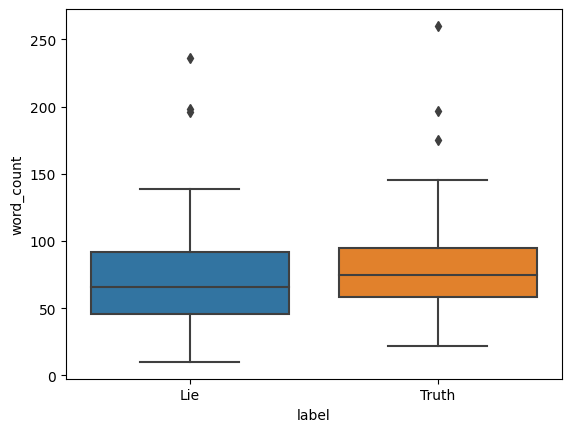

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# create a box plot for the word count feature
sns.boxplot(x='label', y='word_count', data=df_features)
plt.show()


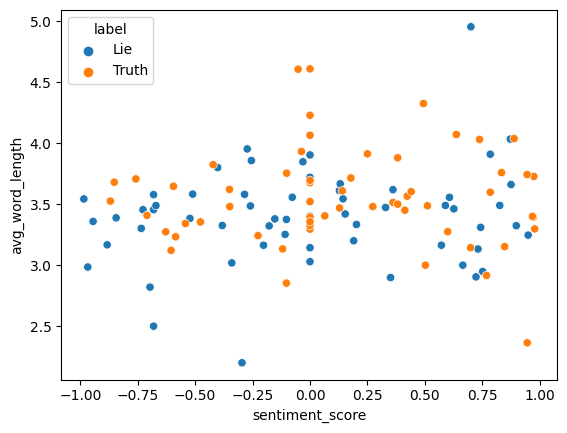

In [ ]:
# create a scatter plot for sentiment score and average word length
sns.scatterplot(x='sentiment_score', y='avg_word_length', hue='label', data=df_features)
plt.show()


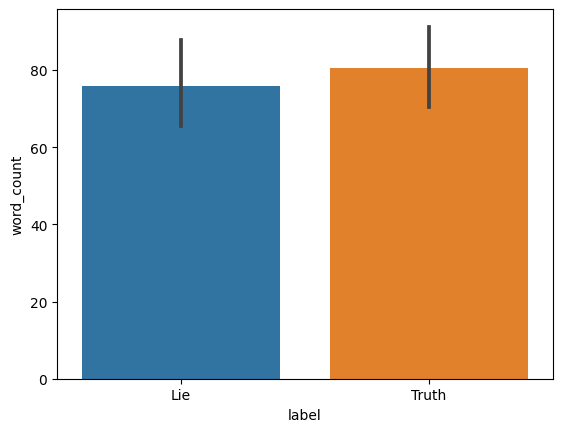

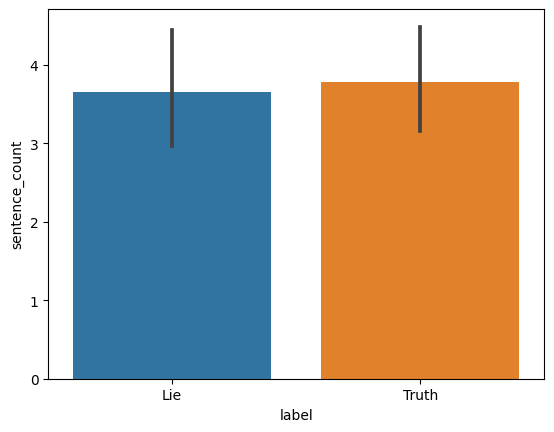

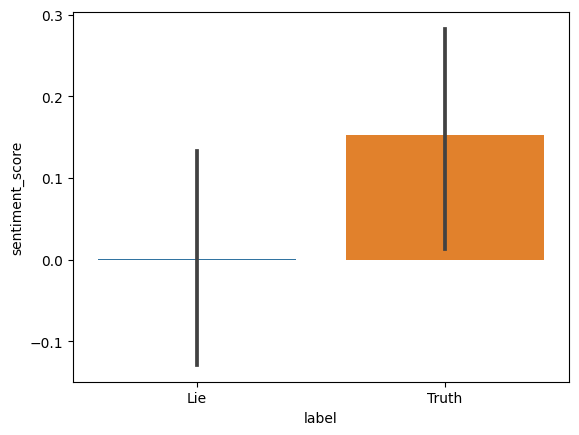

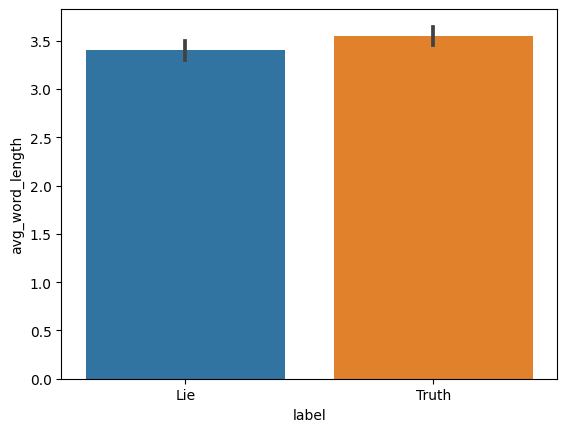

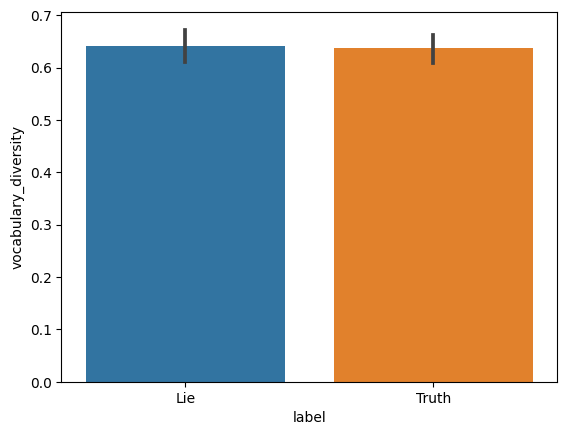

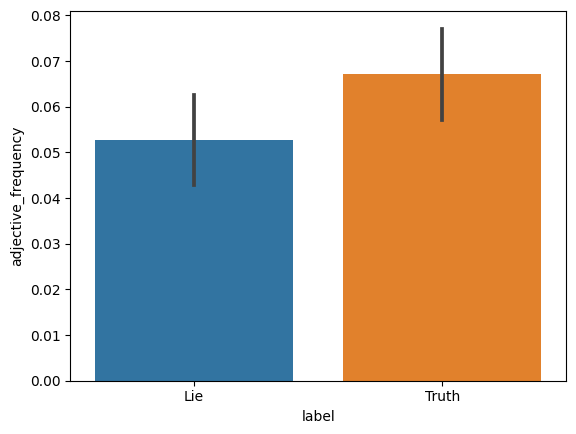

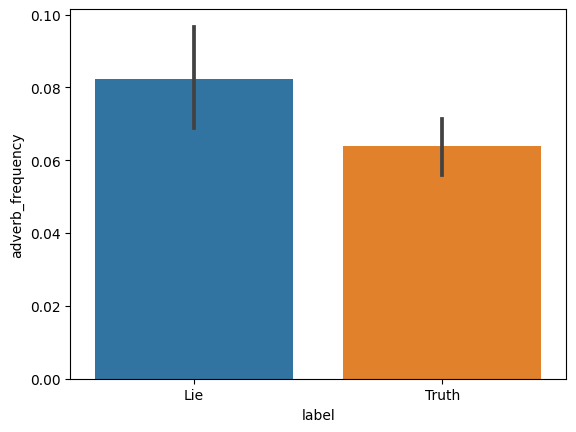

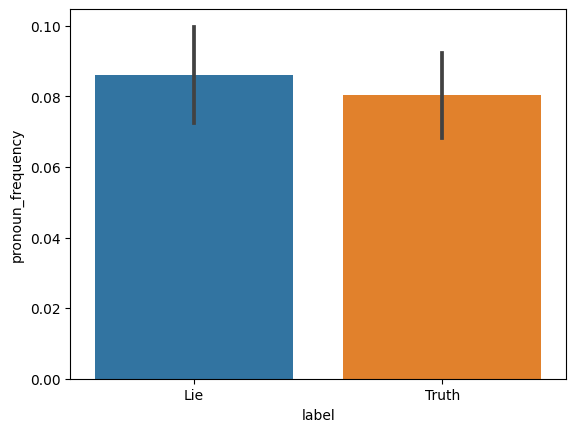

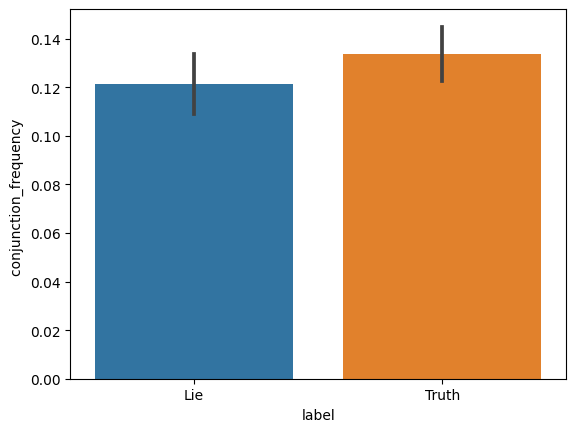

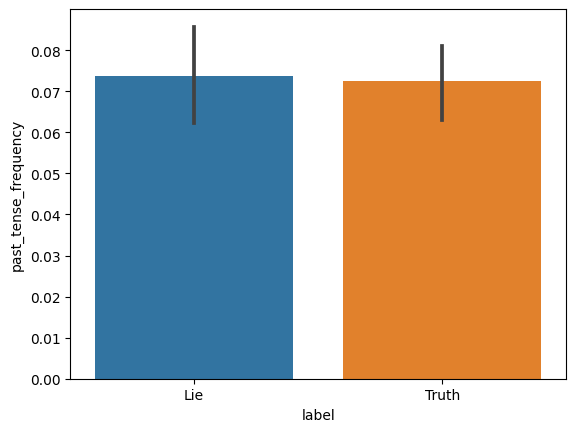

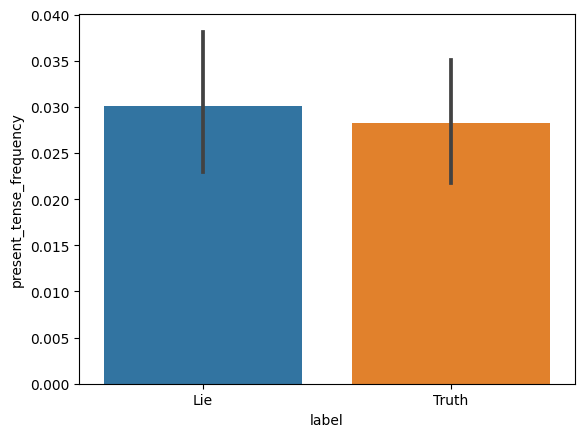

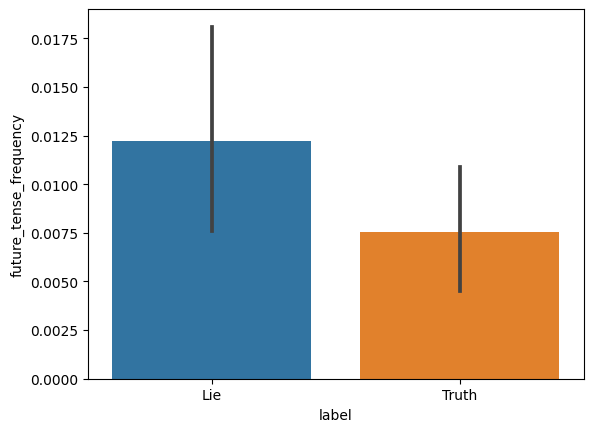

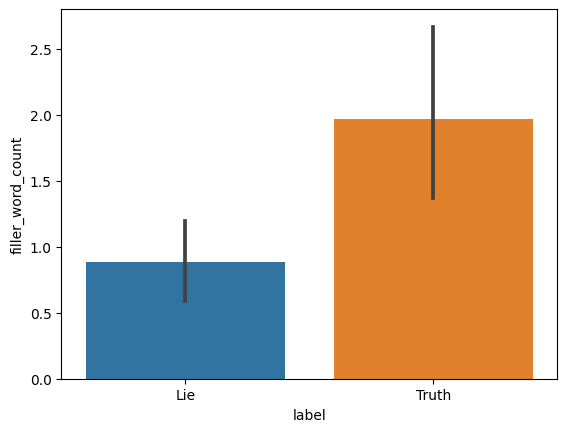

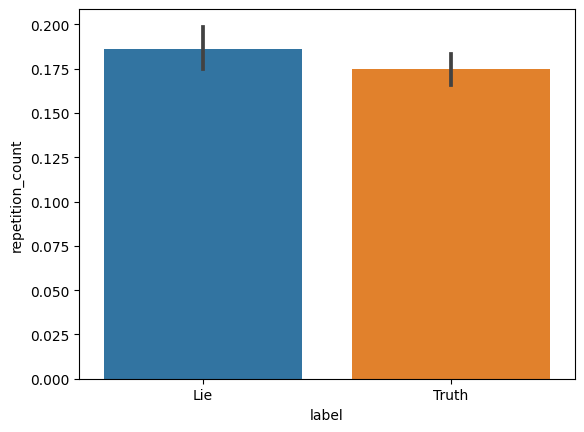

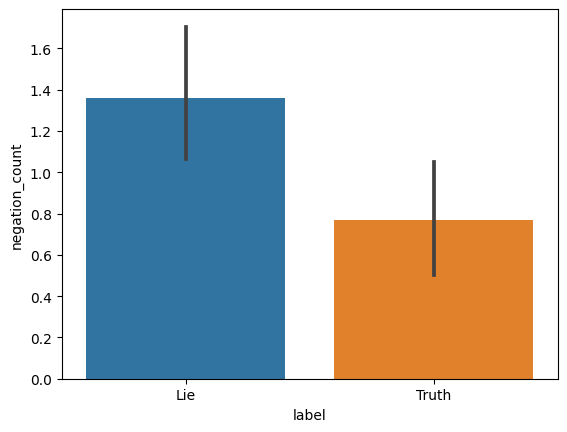

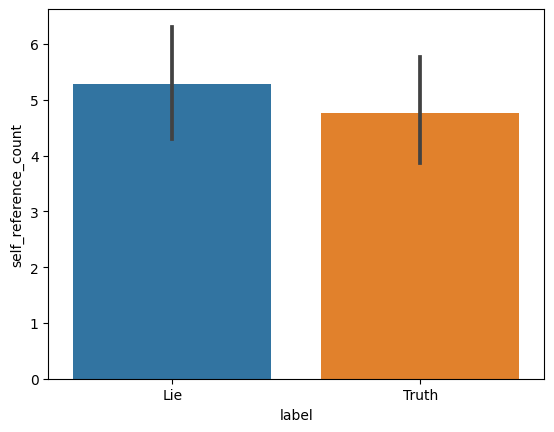

In [ ]:
for col in df_features.columns[1:-1]: # exclude the last column (label)
    sns.barplot(x='label', y=col, data=df_features)
    plt.show()

In [ ]:
from sklearn.feature_selection import SelectKBest, chi2
X = df_features.drop(['Speech','label'], axis=1)
y = df_features['label'].map({'Truth':0, 'Lie':1})
# Select the top 5 features based on their chi-squared scores
#X_new = SelectKBest(chi2, k=5).fit_transform(X, y)
from sklearn.preprocessing import StandardScaler

# Create a StandardScaler object
scaler = StandardScaler()

# Normalize the features in the DataFrame
X_normalized = scaler.fit_transform(X)

# Create a new DataFrame with the normalized features
X_final = pd.DataFrame(X_normalized, columns=X.columns)
X_final

,word_count,sentence_count,sentiment_score,avg_word_length,vocabulary_diversity,adjective_frequency,adverb_frequency,pronoun_frequency,conjunction_frequency,past_tense_frequency,present_tense_frequency,future_tense_frequency,filler_word_count,repetition_count,negation_count,self_reference_count
0,-1.026579,-0.968116,-1.475858,-0.054047,2.163781,-0.752237,-1.617521,-1.627858,-0.138077,0.414712,0.039011,-0.565846,-0.701031,-2.089125,-0.865791,-0.515754
1,1.359133,-0.256006,-0.616161,0.024176,-1.120697,0.319727,0.785120,-0.635538,0.681922,-0.014642,-1.013124,0.677647,-0.207864,0.186102,0.758406,1.012562
2,0.836548,-0.256006,0.210076,-0.697136,-0.349765,0.909306,0.112381,-0.607186,1.179577,-0.689341,0.194544,0.428948,0.285303,0.456670,1.570505,0.503123
3,3.585797,-0.968116,0.524649,0.360536,-1.977226,-0.660825,-0.774561,0.693161,0.716189,1.356198,-0.718883,-0.565846,-0.701031,-0.057524,-0.053692,1.776720
4,-0.140457,-0.612061,-0.196056,0.938021,0.626966,0.596092,0.531508,0.002382,-0.354858,0.561664,-0.530895,1.023061,-0.207864,0.651140,-0.053692,0.503123
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116,-0.185900,-0.256006,1.145337,-0.841503,0.294233,-0.069817,-1.617521,0.328430,0.633046,0.293792,-1.013124,-0.565846,-0.207864,1.123425,-0.865791,0.248404
117,-0.594879,-0.612061,-0.021028,-0.182134,0.482479,1.899971,0.082810,1.758024,1.387731,-0.806116,0.322278,0.534167,1.271638,0.277158,-0.865791,-0.770473
118,-0.753926,-0.256006,-0.139429,-0.304137,-0.149410,1.302360,-1.126315,-1.193127,0.598980,-0.666851,1.301573,-0.565846,0.778471,0.456670,-0.865791,-0.006315
119,-0.435831,-0.968116,-0.139429,0.553230,-0.105264,0.201061,-0.868223,-0.633135,0.534313,0.271248,0.163841,-0.565846,1.271638,0.140243,-0.865791,-1.025193


In [ ]:
import joblib
#from sklearn.externals.joblib import dump, load
from joblib import dump, load

from sklearn.linear_model import LogisticRegression
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.linear_model import LinearRegression
import pandas as pd
import numpy as np
from sklearn import svm
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score
import pandas as pd



In [ ]:
from sklearn.feature_selection import SelectKBest, chi2
X_feature = df_features.drop(['Speech','label'], axis=1)
y = df_features['label'].map({'Truth':0, 'Lie':1})
sffs = SFS(svm.SVC(),
           k_features='best',
           forward=True,
           floating=True,
           scoring = 'f1',
           cv = 5)
#Use SFS to select the top 5 features

sffs.fit(X_feature, y)

#Create a dataframe for the SFS results
df_SFFS_results = pd.DataFrame(sffs.subsets_).transpose()
df_SFFS_results

,feature_idx,cv_scores,avg_score,feature_names
1,"(12,)","[0.7058823529411765, 0.625, 0.6153846153846153...",0.665973,"(filler_word_count,)"
2,"(4, 12)","[0.7058823529411765, 0.625, 0.6153846153846153...",0.665973,"(vocabulary_diversity, filler_word_count)"
3,"(4, 5, 12)","[0.7058823529411765, 0.625, 0.6153846153846153...",0.665973,"(vocabulary_diversity, adjective_frequency, fi..."
4,"(4, 5, 6, 12)","[0.7058823529411765, 0.625, 0.6153846153846153...",0.665973,"(vocabulary_diversity, adjective_frequency, ad..."
5,"(3, 4, 5, 6, 12)","[0.7058823529411765, 0.625, 0.64, 0.6428571428...",0.670896,"(avg_word_length, vocabulary_diversity, adject..."
6,"(3, 4, 5, 6, 7, 12)","[0.7058823529411765, 0.625, 0.64, 0.6428571428...",0.670896,"(avg_word_length, vocabulary_diversity, adject..."
7,"(3, 4, 5, 6, 7, 8, 12)","[0.7058823529411765, 0.625, 0.64, 0.6428571428...",0.670896,"(avg_word_length, vocabulary_diversity, adject..."
8,"(3, 4, 5, 6, 7, 8, 9, 12)","[0.7058823529411765, 0.625, 0.64, 0.6428571428...",0.670896,"(avg_word_length, vocabulary_diversity, adject..."
9,"(3, 4, 5, 6, 7, 8, 9, 10, 12)","[0.7058823529411765, 0.625, 0.64, 0.6428571428...",0.670896,"(avg_word_length, vocabulary_diversity, adject..."
10,"(3, 4, 5, 6, 7, 8, 9, 10, 11, 12)","[0.7058823529411765, 0.625, 0.64, 0.6428571428...",0.670896,"(avg_word_length, vocabulary_diversity, adject..."


In [ ]:
print(sffs.k_feature_idx_)
print(sffs.k_feature_names_)

(3, 4, 5, 6, 12)
('avg_word_length', 'vocabulary_diversity', 'adjective_frequency', 'adverb_frequency', 'filler_word_count')


In [ ]:
# Get the performance scores for each feature subset
metric_dict = sffs.get_metric_dict()

# Extract the scores and corresponding feature subsets
scores = [metric_dict[k]['avg_score'] for k in metric_dict.keys()]
feature_subsets = [k for k in metric_dict.keys()]

# Create a DataFrame to store the scores and feature subsets
df_scores = pd.DataFrame({'Feature Subset': feature_subsets, 'Score': scores})

# Sort the DataFrame by the scores in descending order
df_scores_sorted = df_scores.sort_values('Score', ascending=False)

# Print the ranked features
print(df_scores_sorted['Feature Subset'])


4      5
5      6
6      7
7      8
8      9
9     10
10    11
0      1
1      2
2      3
3      4
11    12
12    13
13    14
14    15
15    16
Name: Feature Subset, dtype: int64


In [ ]:
# Get the performance scores and corresponding feature subsets
metric_dict = sffs.get_metric_dict()
scores = [metric_dict[k]['avg_score'] for k in metric_dict.keys()]
feature_subsets = [k for k in metric_dict.keys()]

# Get the feature indices and names for the selected features
selected_feature_indices = sffs.k_feature_idx_
selected_feature_names = sffs.k_feature_names_

# Create a DataFrame to store the scores, feature subset indices, and names
df_scores_features = pd.DataFrame({
    'Feature Subset': feature_subsets,
    'Score': scores,
    'Feature Indices': [sffs.subsets_[k]['feature_idx'] for k in feature_subsets],
    'Feature Names': [selected_feature_names for _ in feature_subsets]
})

# Sort the DataFrame by the scores in descending order
df_scores_features_sorted = df_scores_features.sort_values('Score', ascending=False)

# Print the ranked features
for idx, row in df_scores_features_sorted.iterrows():
    print("Feature Subset:", row['Feature Subset'])
    print("Score:", row['Score'])
    print("Feature Indices:", row['Feature Indices'])
    print("Feature Names:", row['Feature Names'])
    print()


Feature Subset: 5
Score: 0.670896047307812
Feature Indices: (3, 4, 5, 6, 12)
Feature Names: ('avg_word_length', 'vocabulary_diversity', 'adjective_frequency', 'adverb_frequency', 'filler_word_count')

Feature Subset: 6
Score: 0.670896047307812
Feature Indices: (3, 4, 5, 6, 7, 12)
Feature Names: ('avg_word_length', 'vocabulary_diversity', 'adjective_frequency', 'adverb_frequency', 'filler_word_count')

Feature Subset: 7
Score: 0.670896047307812
Feature Indices: (3, 4, 5, 6, 7, 8, 12)
Feature Names: ('avg_word_length', 'vocabulary_diversity', 'adjective_frequency', 'adverb_frequency', 'filler_word_count')

Feature Subset: 8
Score: 0.670896047307812
Feature Indices: (3, 4, 5, 6, 7, 8, 9, 12)
Feature Names: ('avg_word_length', 'vocabulary_diversity', 'adjective_frequency', 'adverb_frequency', 'filler_word_count')

Feature Subset: 9
Score: 0.670896047307812
Feature Indices: (3, 4, 5, 6, 7, 8, 9, 10, 12)
Feature Names: ('avg_word_length', 'vocabulary_diversity', 'adjective_frequency', 'adver

In [ ]:
#X = X.iloc[:, list(sffs.k_feature_idx_)]
X = X_feature.copy()

# SVM

In [ ]:

np.random.seed(42) # set the seed to 42
from sklearn.model_selection import GridSearchCV, cross_validate

# get the feature matrix X and target vector y from your dataframe
X = X.iloc[:, list(sffs.k_feature_idx_)]
#y = df_features['label'].map({'Truth':0, 'Lie':1})

# define the SVM model
svm_model = svm.SVC()

# define the parameter grid to search
param_grid = {
    'C': [0.001, 0.1, 1, 10, 100,1000],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma': ['scale', 'auto']
}

# define the grid search object
grid_search = GridSearchCV(svm_model, param_grid, cv=5, scoring='f1')

# fit the grid search object to the data
grid_search.fit(X, y)

# print the best hyperparameters
print("Best parameters:", grid_search.best_params_)

# get the best model from the grid search object
best_svm_model = grid_search.best_estimator_

# compute f1-score and accuracy on 5-fold cross-validation
f1_scores = cross_val_score(best_svm_model, X, y, cv=5, scoring='f1')
#train_accuracy_scores = cross_val_score(best_svm_model, X, y, cv=5, scoring='accuracy', return_train_score=True, random_state= 42)
#test_accuracy_scores = cross_val_score(best_svm_model, X, y, cv=5, scoring='accuracy', random_state= 42)
#train_accuracy_scores = cross_validate(best_svm_model, X, y, cv=5, scoring='accuracy', return_train_score=True)
#test_accuracy_scores = cross_val_score(best_svm_model, X, y, cv=5, scoring='accuracy')
accuracy_scores = cross_validate(best_svm_model, X, y, cv=5, scoring='accuracy', return_train_score=True)
# print the mean and standard deviation of the scores
#print("Train Accuracy: %0.2f (+/- %0.2f)" % (train_accuracy_scores.mean(), train_accuracy_scores.std() * 2))
#print("Test Accuracy: %0.2f (+/- %0.2f)" % (test_accuracy_scores.mean(), test_accuracy_scores.std() * 2))
print("Training Accuaracy: ", accuracy_scores['train_score'].mean())
print("Test Accuaracy: ", accuracy_scores['test_score'].mean())

print("F1-score: ", f1_scores.mean())


Best parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}
Training Accuaracy:  0.6446091065292096
Test Accuaracy:  0.6366666666666666
F1-score:  0.6979713423831072


In [ ]:
accuracy_scores

{'fit_time': array([0.00396276, 0.00378919, 0.00549293, 0.00359631, 0.00389671]),
 'score_time': array([0.00265837, 0.00281429, 0.00249982, 0.0025506 , 0.00256371]),
 'test_score': array([0.6       , 0.5       , 0.66666667, 0.625     , 0.79166667]),
 'train_score': array([0.63541667, 0.63917526, 0.6185567 , 0.67010309, 0.65979381])}

# LOGISTIC REGRESSION

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, accuracy_score


('avg_word_length', 'vocabulary_diversity', 'adjective_frequency', 'adverb_frequency', 'filler_word_count')
# define the logistic regression model
log_reg = LogisticRegression(solver='sag', random_state=42, max_iter=5000)

# define the parameter grid to search
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100]
    }

# define the grid search object
grid_search = GridSearchCV(log_reg, param_grid, cv=5, scoring='f1')

# fit the grid search object to the data
grid_search.fit(X, y)

# print the best hyperparameters
print("Best parameters:", grid_search.best_params_)

# get the best model from the grid search object
best_log_reg = grid_search.best_estimator_

# compute f1-score and accuracy on 5-fold cross-validation
f1_scores = cross_val_score(best_log_reg, X, y, cv=5, scoring='f1')
#accuracy_scores = cross_val_score(best_log_reg, X, y, cv=5, scoring='accuracy')

# print the mean and standard deviation of the scores
#print("F1-score: %0.2f (+/- %0.2f)" % (f1_scores.mean(), f1_scores.std() * 2))
#print("Accuracy: %0.2f (+/- %0.2f)" % (accuracy_scores.mean(), accuracy_scores.std() * 2))
accuracy_scores = cross_validate(best_log_reg, X, y, cv=5, scoring='accuracy', return_train_score=True)
# print the mean and standard deviation of the scores
#print("Train Accuracy: %0.2f (+/- %0.2f)" % (train_accuracy_scores.mean(), train_accuracy_scores.std() * 2))
#print("Test Accuracy: %0.2f (+/- %0.2f)" % (test_accuracy_scores.mean(), test_accuracy_scores.std() * 2))
print("Training Accuaracy: ", accuracy_scores['train_score'].mean())
print("Test Accuaracy: ", accuracy_scores['test_score'].mean())

print("F1-score: ", f1_scores.mean())

Best parameters: {'C': 10}
Training Accuaracy:  0.6611254295532645
Test Accuaracy:  0.6853333333333333
F1-score:  0.7169483419806


In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()

# Define the parameter grid to search
param_grid = {
    'n_neighbors': [3, 5, 7],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}

# Define the grid search object
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='f1')

# Fit the grid search object to the data
grid_search.fit(X, y)

# Print the best hyperparameters
print("Best parameters:", grid_search.best_params_)

# Get the best model from the grid search object
best_knn = grid_search.best_estimator_

# Compute f1-score and accuracy on 5-fold cross-validation
f1_scores = cross_val_score(best_knn, X, y, cv=5, scoring='f1')
#accuracy_scores = cross_val_score(best_knn, X, y, cv=5, scoring='accuracy')

# Print the mean and standard deviation of the scores
#print("F1-score: %0.2f (+/- %0.2f)" % (f1_scores.mean(), f1_scores.std() * 2))
#print("Accuracy: %0.2f (+/- %0.2f)" % (accuracy_scores.mean(), accuracy_scores.std() * 2))
accuracy_scores = cross_validate(best_knn, X, y, cv=5, scoring='accuracy', return_train_score=True)
# print the mean and standard deviation of the scores
#print("Train Accuracy: %0.2f (+/- %0.2f)" % (train_accuracy_scores.mean(), train_accuracy_scores.std() * 2))
#print("Test Accuracy: %0.2f (+/- %0.2f)" % (test_accuracy_scores.mean(), test_accuracy_scores.std() * 2))
print("Training Accuaracy: ", accuracy_scores['train_score'].mean())
print("Test Accuaracy: ", accuracy_scores['test_score'].mean())

print("F1-score: ", f1_scores.mean())

Best parameters: {'n_neighbors': 7, 'p': 2, 'weights': 'uniform'}
Training Accuaracy:  0.7169458762886598
Test Accuaracy:  0.6283333333333333
F1-score:  0.6307359307359308


In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score
import pandas as pd

# define the decision tree model
dt = DecisionTreeClassifier(random_state=42)

# define the parameter grid to search
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 4, 6]
}

# define the grid search object
grid_search = GridSearchCV(dt, param_grid, cv=5, scoring='f1')

# fit the grid search object to the data
grid_search.fit(X, y)

# print the best hyperparameters
print("Best parameters:", grid_search.best_params_)

# get the best model from the grid search object
best_dt = grid_search.best_estimator_

# compute f1-score and accuracy on 5-fold cross-validation
f1_scores = cross_val_score(best_dt, X, y, cv=5, scoring='f1')
#accuracy_scores = cross_val_score(best_dt, X, y, cv=5, scoring='accuracy')

# print the mean and standard deviation of the scores
#print("F1-score: %0.2f (+/- %0.2f)" % (f1_scores.mean(), f1_scores.std() * 2))
#print("Accuracy: %0.2f (+/- %0.2f)" % (accuracy_scores.mean(), accuracy_scores.std() * 2))
accuracy_scores = cross_validate(best_dt, X, y, cv=5, scoring='accuracy', return_train_score=True)
# print the mean and standard deviation of the scores
#print("Train Accuracy: %0.2f (+/- %0.2f)" % (train_accuracy_scores.mean(), train_accuracy_scores.std() * 2))
#print("Test Accuracy: %0.2f (+/- %0.2f)" % (test_accuracy_scores.mean(), test_accuracy_scores.std() * 2))
print("Training Accuaracy: ", accuracy_scores['train_score'].mean())
print("Test Accuaracy: ", accuracy_scores['test_score'].mean())

print("F1-score: %0.2f (+/- %0.2f)" % (f1_scores.mean(), f1_scores.std() * 2))


Best parameters: {'criterion': 'entropy', 'max_depth': 7, 'min_samples_split': 2}
Training Accuaracy:  0.7830970790378008
Test Accuaracy:  0.4959999999999999
F1-score: 0.52 (+/- 0.20)


In [ ]:
!pip install xgboost

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import f1_score



# split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# define the XGBoost model
xgb = XGBClassifier()

# define the hyperparameters to search over
params = {
    'learning_rate': [0.01, 0.1, 0.5],
    'max_depth': [3, 5, 7],
    'n_estimators': [50, 100, 200]
}

# perform grid search with cross-validation
grid_search = GridSearchCV(xgb, params, cv=5, scoring='accuracy')
grid_search.fit(X, y)

# print the best hyperparameters
print("Best parameters:", grid_search.best_params_)

# get the best model from the grid search object
best_xgb = grid_search.best_estimator_

# compute f1-score and accuracy on 5-fold cross-validation
f1_scores = cross_val_score(best_xgb, X, y, cv=5, scoring='f1')
#accuracy_scores = cross_val_score(best_dt, X, y, cv=5, scoring='accuracy')

# print the mean and standard deviation of the scores
#print("F1-score: %0.2f (+/- %0.2f)" % (f1_scores.mean(), f1_scores.std() * 2))
#print("Accuracy: %0.2f (+/- %0.2f)" % (accuracy_scores.mean(), accuracy_scores.std() * 2))
accuracy_scores = cross_validate(best_xgb, X, y, cv=5, scoring='accuracy', return_train_score=True)
# print the mean and standard deviation of the scores
#print("Train Accuracy: %0.2f (+/- %0.2f)" % (train_accuracy_scores.mean(), train_accuracy_scores.std() * 2))
#print("Test Accuracy: %0.2f (+/- %0.2f)" % (test_accuracy_scores.mean(), test_accuracy_scores.std() * 2))
print("Training Accuaracy: ", accuracy_scores['train_score'].mean())
print("Test Accuaracy: ", accuracy_scores['test_score'].mean())

print("F1-score: %0.2f (+/- %0.2f)" % (f1_scores.mean(), f1_scores.std() * 2))


Best parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50}
Training Accuaracy:  0.9772981099656357
Test Accuaracy:  0.5793333333333333
F1-score: 0.60 (+/- 0.09)


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score
import pandas as pd


# Define parameter grid to search
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

# Define random forest classifier
rfc = RandomForestClassifier(random_state=42)

# Define grid search object
grid_search = GridSearchCV(rfc, param_grid, cv=5, scoring='f1')

# Fit grid search object to the data
grid_search.fit(X, y)

# Print best hyperparameters
print("Best parameters: ", grid_search.best_params_)

# Get best model from grid search object
best_rfc = grid_search.best_estimator_

# Compute f1-score and accuracy on 5-fold cross-validation
f1_scores = cross_val_score(best_rfc, X, y, cv=5, scoring='f1')
accuracy_scores = cross_val_score(best_rfc, X, y, cv=5, scoring='accuracy')

# Print mean and standard deviation of the scores
print("F1-score: %0.2f (+/- %0.2f)" % (f1_scores.mean(), f1_scores.std() * 2))
print("Accuracy: %0.2f (+/- %0.2f)" % (accuracy_scores.mean(), accuracy_scores.std() * 2))


Best parameters:  {'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
F1-score: 0.61 (+/- 0.10)
Accuracy: 0.60 (+/- 0.22)
